In [1]:
import sys
sys.path.append('./codes/forgraph/')
from config import args
from sklearn.metrics import roc_auc_score
from models import GCN
from metrics import *
import numpy as np
from Explainer import Explainer
from scipy.sparse import coo_matrix,csr_matrix
import networkx as nx
skip = 5
topk = 5
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl


args.elr = 0.003
args.coff_t0=5.0
args.coff_t0=1.0
args.coff_size = 0.00
args.coff_ent = 0.000



In [2]:
with open('./dataset/BA-2motif.pkl','rb') as fin:
    adjs,features,labels = pkl.load(fin)

model = GCN(input_dim=features.shape[-1], output_dim=labels.shape[1])
model.load_weights(args.save_path+args.dataset)


embs = model.getNodeEmb((tf.convert_to_tensor(features,dtype=tf.float32),\
                               tf.convert_to_tensor(adjs,dtype=tf.float32)), training=False)
outputs = model.call((tf.convert_to_tensor(features,dtype=tf.float32),\
                            tf.convert_to_tensor(adjs,dtype=tf.float32)),training=False)
pred_label = tf.argmax(outputs, 1)

acc = accuracy(outputs, labels)
print('model acc',acc.numpy())

embs = model.getNodeEmb((tf.convert_to_tensor(features,dtype=tf.float32),\
                               tf.convert_to_tensor(adjs,dtype=tf.float32)), training=False)
outputs = model.call((tf.convert_to_tensor(features,dtype=tf.float32),\
                            tf.convert_to_tensor(adjs,dtype=tf.float32)),training=False)
pred_label = tf.argmax(outputs, 1)


model acc 1.0


In [3]:
if args.setting==1:
    allnodes = [i for i in range(0,100)]
elif args.setting==2:
    allnodes = [i for i in range(0,100)]
    allnodes.extend([i for i in range(500,600)])
elif args.setting==3:
    allnodes=[i for i in range(1000)]
explainer = Explainer(model=model,nodesize=adjs.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=args.elr)


In [4]:
def acc(adj,insert):
    mask = explainer.masked_adj.numpy()
    adj = coo_matrix(adj)
    for r,c in list(zip(adj.row,adj.col)):
        if r>=insert and r<insert+skip and c>=insert and c<insert+skip:
            reals.append(1)
        else:
            reals.append(0)
        preds.append(mask[r][c])

In [6]:
def explain_graph(gid):
    fea,emb,adj,label,graphid = features[gid], embs[gid], adjs[gid], labels[gid], gid
    explainer((fea,emb,adj,1.0,label))
    insert = 20
    acc(adj,insert)

In [7]:
def test():
    global preds
    global reals
    preds = []
    reals = []
    for gid in allnodes:
        explain_graph(gid)
    auc = roc_auc_score(reals,preds)
    return auc

In [8]:
def train():
    epochs = 10
    t0 = args.coff_t0
    t1 = args.coff_te

    for epoch in range(epochs):
        if epoch%1==0:
            auc = test()
            print('auc',auc)

            
        loss = 0
        tmp = float(t0 * np.power(t1 / t0, epoch /epochs))
        train_instances = [ins for ins in range(adjs.shape[0])]
        np.random.shuffle(train_instances)
        for gid in train_instances:
            with tf.GradientTape() as tape:
                pred = explainer((features[gid],embs[gid],adjs[gid],tmp, labels[gid]),training=True)
                loss += explainer.loss(pred, labels[gid])
                
#         train_variables = [para for para in explainer.trainable_variables
#                            if para.name.startswith('explainer')]
        train_variables = [para for para in explainer.trainable_variables]
        grads = tape.gradient(loss, train_variables)
        optimizer.apply_gradients(zip(grads, train_variables))
        print('epoch',epoch,'loss',loss.numpy())


In [9]:
train()

auc 0.5512461744140454
epoch 0 loss 4010.122
auc 0.4208197872193663
epoch 1 loss 3189.9348
auc 0.4127957000958439
epoch 2 loss 2663.1658
auc 0.41047459502338013
epoch 3 loss 2282.934
auc 0.40920529918532716
epoch 4 loss 1994.7372
auc 0.40732812999186785
epoch 5 loss 1772.0656
auc 0.4052312051639511
epoch 6 loss 1613.6486
auc 0.402533554427696
epoch 7 loss 1542.915
auc 0.39367174112718195
epoch 8 loss 1474.3911
auc 0.3644072565420696
epoch 9 loss 1457.0272


In [10]:
auc = test()
print(auc)

0.30968560762830005


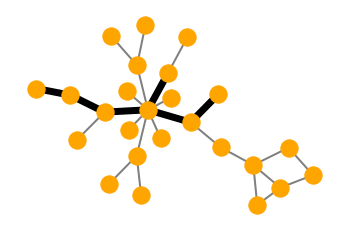

<Figure size 432x288 with 0 Axes>

In [11]:
gid = 501
topk=6
fea,emb,adj,label,graphid = features[gid], embs[gid], adjs[gid], labels[gid], gid
explainer((fea,emb,adj,1.0,label))
plot(adj,label,graphid)


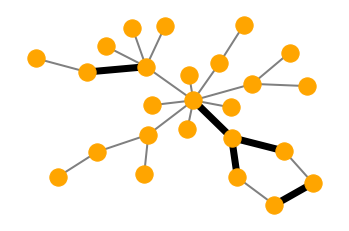

<Figure size 432x288 with 0 Axes>

In [12]:
gid = 1
topk=5
fea,emb,adj,label,graphid = features[gid], embs[gid], adjs[gid], labels[gid], gid
explainer((fea,emb,adj,1.0,label))
plot(adj,label,graphid)